# Model and Metrics Modules Imports

In [180]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [181]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# used to split a dataset into training and testing subsets.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Reading The Dataset

In [182]:
df=pd.read_csv("train.csv")

Main


In [183]:
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [184]:
df.drop(columns=['TWF','HDF','PWF','OSF','RNF'],axis=0,inplace=True)

In [185]:
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,0,L50096,L,300.6,309.6,1596,36.1,140,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 9.4+ MB


# Handling Categorical Data

In [187]:
ts=pd.get_dummies(df['Type'],drop_first=False)

In [188]:
ts.head()

,H,L,M
0,False,True,False
1,False,False,True
2,False,True,False
3,False,True,False
4,False,False,True


In [189]:
mapping_boolean = {True: 1, False: 0}
ts['H'] = ts['H'].map(mapping_boolean)
ts['L'] = ts['L'].map(mapping_boolean)
ts['M'] = ts['M'].map(mapping_boolean)

In [190]:
df=pd.concat([df, ts], axis=1)

In [191]:
df.drop(['id','Product ID','Type'],axis=1,inplace=True)

In [192]:
df.nunique()

,0
Air temperature [K],95
Process temperature [K],81
Rotational speed [rpm],952
Torque [Nm],611
Tool wear [min],246
Machine failure,2
H,2
L,2
M,2


In [193]:
failure_ = df[df['Machine failure']==1]
ok_ = df[df['Machine failure']==0]

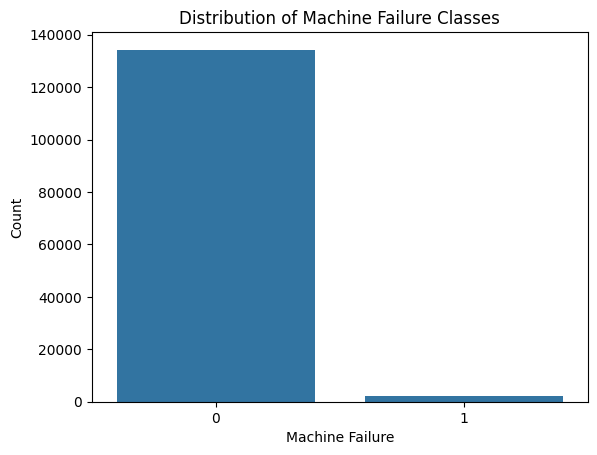

In [194]:
sns.countplot(data=df, x='Machine failure')

# Adding labels
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.title('Distribution of Machine Failure Classes')
plt.show()

In [195]:
print("Failure ",len(failure_))
print("Fine ",len(ok_))

Failure  2148
Fine  134281


# Our Data Is Imbalanced
- This may cause over fitting the models
- So I choose SMOTE to balance my dataset

# Making Imbalance Dataset into Balanced Dataset

In [196]:
# Make the Imbalance Data into Balanced Data
from imblearn.over_sampling import SMOTE

# Create a SMOTE object
smote = SMOTE(random_state=42)
Y = df['Machine failure']
X = df.drop(['Machine failure'], axis=1)
# Fit the SMOTE object to the  data and oversample the minority class
X, Y = smote.fit_resample(X, Y)
df = pd.concat([X,Y], axis=1)


In [197]:
X.shape

(268562, 8)

In [198]:
Y.shape

(268562,)

In [199]:
df.shape

(268562, 9)

In [200]:
df.nunique()

,0
Air temperature [K],122630
Process temperature [K],122194
Rotational speed [rpm],1534
Torque [Nm],127053
Tool wear [min],254
H,2
L,2
M,2
Machine failure,2


In [201]:
failure_ = df[df['Machine failure']==1]
ok_ = df[df['Machine failure']==0]

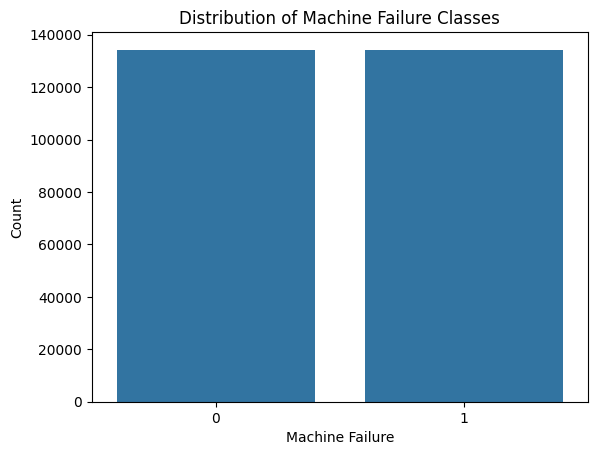

In [202]:
sns.countplot(data=df, x='Machine failure')

# Adding labels
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.title('Distribution of Machine Failure Classes')
plt.show()

In [203]:
print("After balancing failure : ",len(failure_))
print("After balancing ok : ",len(ok_))

After balancing failure :  134281
After balancing ok :  134281


# Feature Selection

In [204]:
y = df['Machine failure']
X = df.drop(['Machine failure'], axis=1)
feature_names = list(X.columns)
## finding feature Importance by Random Forest
rfc = RandomForestClassifier()
rfc.fit(X,y)
rfc_scores = rfc.feature_importances_.argsort()
rfc_scores_sorted_indices = rfc_scores[::-1]
rfc_features_sorted = [feature_names[i] for i in rfc_scores_sorted_indices][:6]

In [205]:
X = X[list(rfc_features_sorted)]
X.shape

(268562, 6)

In [206]:
df = pd.concat([X,y], axis=1)

In [207]:
df.head(10)

,Rotational speed [rpm],Torque [Nm],Tool wear [min],Air temperature [K],Process temperature [K],M,Machine failure
0,1596,36.1,140,300.6,309.6,0,0
1,1759,29.1,200,302.6,312.1,1,0
2,1805,26.5,25,299.3,308.5,0,0
3,1524,44.3,197,301.0,310.9,0,0
4,1641,35.4,34,298.0,309.0,1,0
5,1429,42.1,65,298.4,308.9,1,0
6,1413,42.9,156,299.6,311.0,0,0
7,1609,38.1,67,298.7,310.1,0,0
8,1578,35.2,13,297.7,308.8,0,0
9,1447,53.3,98,300.5,312.3,0,0


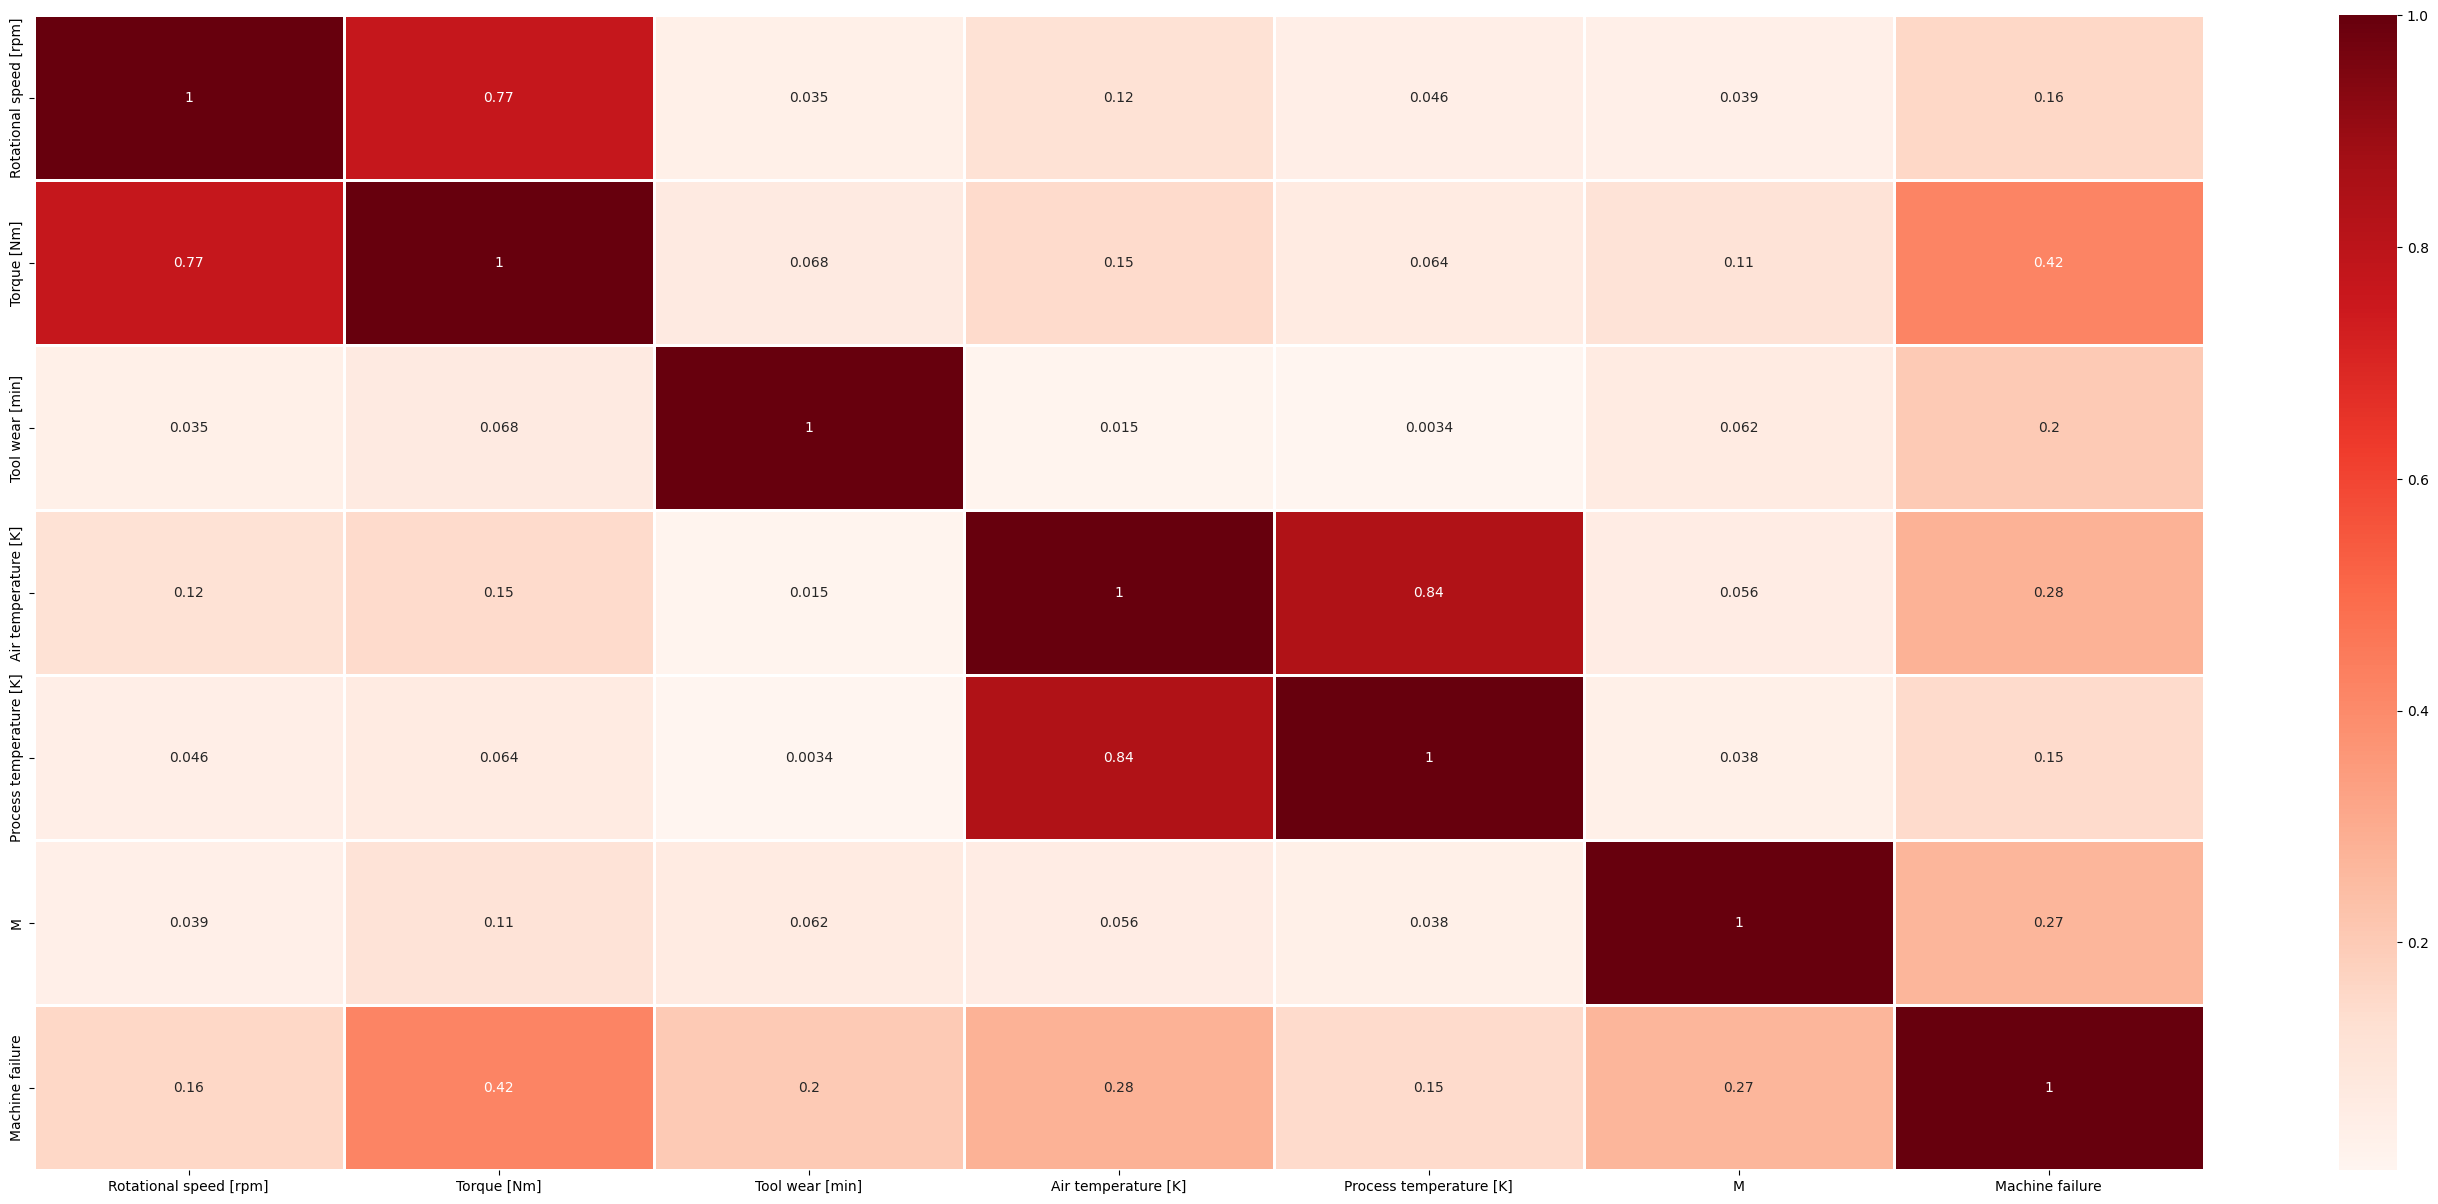

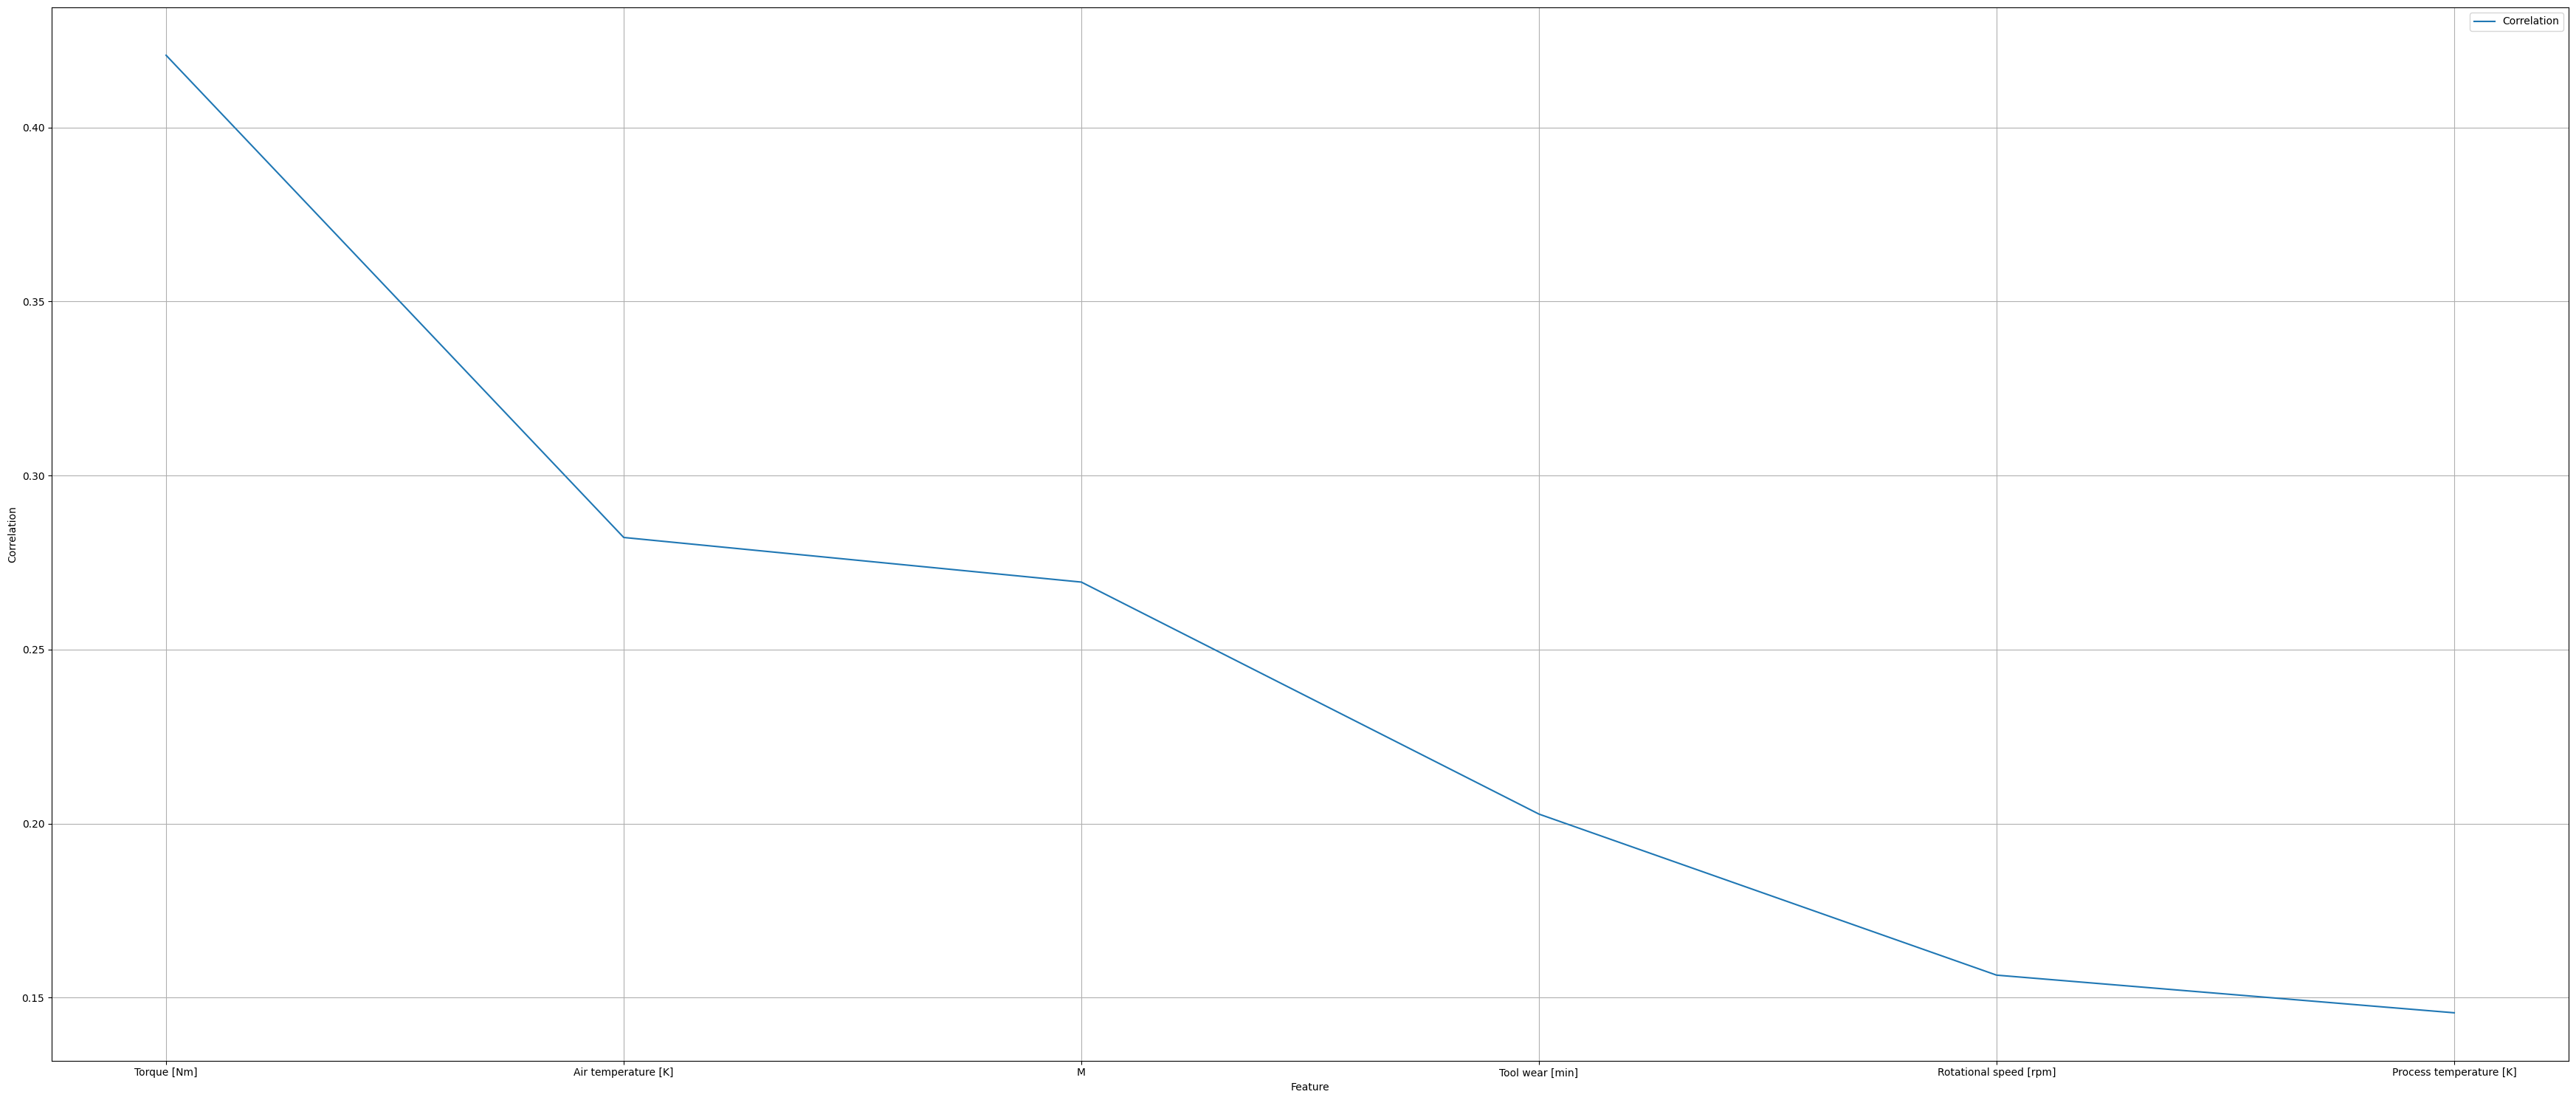

In [208]:
# Plot feature correlations with target variable in our case attrition
plt.figure(figsize=(35,15))
corr=abs(df.corr())
sns.heatmap(corr,annot=True,linewidth=1,cmap="Reds")
plt.figure(figsize=(35,15))
plt.plot(corr["Machine failure"].sort_values(ascending=False)[1:],label="Correlation")
plt.ylabel("Correlation")
plt.xlabel("Feature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [209]:
results_test = {
    'Logistic Regression Classifier': 0.0,
    'Decision Tree Classifier':0.0,
    'Random Forest Classifier':0.0,
    'K-Nearest-Neighbor Classifier':0.0,
    'XGBoost Classifier':0.0,
    'LightGBM Classifier':0.0,
    'CatBoost Classifier':0.0,
}

In [210]:
X.columns = X.columns.str.replace('[', ' in ')
X.columns = X.columns.str.replace(']', '')
X.columns = X.columns.str.replace(' ', '-')

In [211]:
# split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [212]:
X_train.shape

(187993, 6)

In [213]:
X_test.shape

(80569, 6)

# Initializing the models and Train Them

In [214]:
# Initialize all models with basic parameters
rf_model = RandomForestClassifier(verbose=0)
knn_model = KNeighborsClassifier()
dt_model = DecisionTreeClassifier()
lr_model = LogisticRegression()
xgb_model = XGBClassifier(verbosity=0)
lgbm_model = LGBMClassifier(verbose=-1)
catboost_model = CatBoostClassifier(verbose=False)

In [215]:
## Training All the models
# Fit Random Forest Classifier
rf_model.fit(X_train, y_train)

# Fit K Nearest Neighbors Classifier
knn_model.fit(X_train, y_train)

# Fit Decision Tree Classifier
dt_model.fit(X_train, y_train)

# Fit Logistic Regression
lr_model.fit(X_train, y_train)

# Fit XGBoost Classifier
xgb_model.fit(X_train, y_train)

# Fit LightGBM Classifier
lgbm_model.fit(X_train, y_train)

# Fit CatBoost Classifier
catboost_model.fit(X_train, y_train)


# Testing Each Trained Model

In [216]:
## Logistic Regression Model
y_pred = lr_model.predict(X_test)
#evaluation

cm = confusion_matrix(y_test,y_pred)
TP = cm[1, 1]
FN = cm[1, 0]
sensitivity = TP / (TP + FN)
sensitivity = "{:2f}".format(sensitivity)
print(f"Sensitivity (Recall): ", sensitivity)
print(classification_report(y_test, y_pred))
results_test['Logistic Regression Classifier'] = accuracy_score(y_test,y_pred)

Sensitivity (Recall):  0.789023
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     40285
           1       0.79      0.79      0.79     40284

    accuracy                           0.79     80569
   macro avg       0.79      0.79      0.79     80569
weighted avg       0.79      0.79      0.79     80569



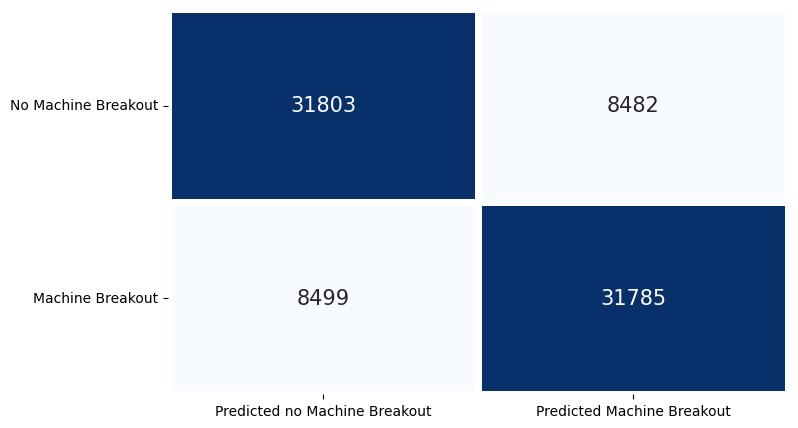

In [217]:
# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
            yticklabels = ['No Machine Breakout', 'Machine Breakout'], xticklabels = ['Predicted no Machine Breakout', 'Predicted Machine Breakout'])
plt.yticks(rotation = 0)
plt.show()

In [218]:
# Decision Tree Classifier
y_pred = dt_model.predict(X_test)
#evaluation

cm = confusion_matrix(y_test,y_pred)
TP = cm[1, 1]
FN = cm[1, 0]
sensitivity = TP / (TP + FN)
sensitivity = "{:2f}".format(sensitivity)
print(f"Sensitivity (Recall): ", sensitivity)
print(classification_report(y_test, y_pred))
results_test['Decision Tree Classifier'] = accuracy_score(y_test,y_pred)

Sensitivity (Recall):  0.970063
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     40285
           1       0.96      0.97      0.96     40284

    accuracy                           0.96     80569
   macro avg       0.96      0.96      0.96     80569
weighted avg       0.96      0.96      0.96     80569



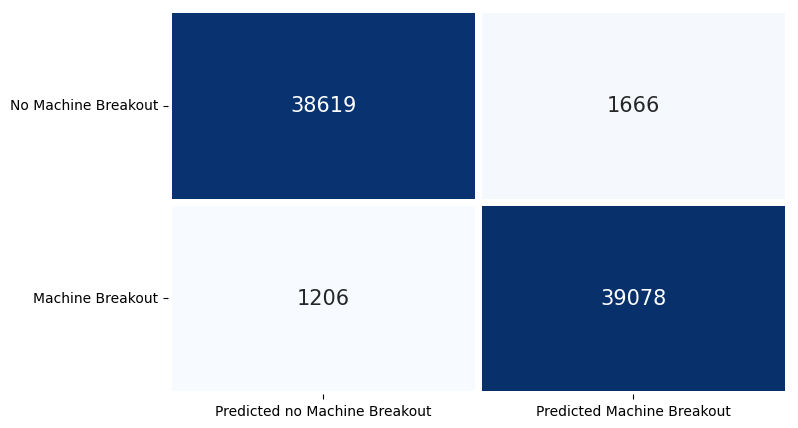

In [219]:
# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
            yticklabels = ['No Machine Breakout', 'Machine Breakout'], xticklabels = ['Predicted no Machine Breakout', 'Predicted Machine Breakout'])
plt.yticks(rotation = 0)
plt.show()

In [220]:
# Random Forest Classifier
y_pred = rf_model.predict(X_test)
#evaluation

cm = confusion_matrix(y_test,y_pred)
TP = cm[1, 1]
FN = cm[1, 0]
sensitivity = TP / (TP + FN)
sensitivity = "{:2f}".format(sensitivity)
print(f"Sensitivity (Recall): ", sensitivity)
print(classification_report(y_test, y_pred))
results_test['Random Forest Classifier'] = accuracy_score(y_test,y_pred)

Sensitivity (Recall):  0.983840
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     40285
           1       0.98      0.98      0.98     40284

    accuracy                           0.98     80569
   macro avg       0.98      0.98      0.98     80569
weighted avg       0.98      0.98      0.98     80569



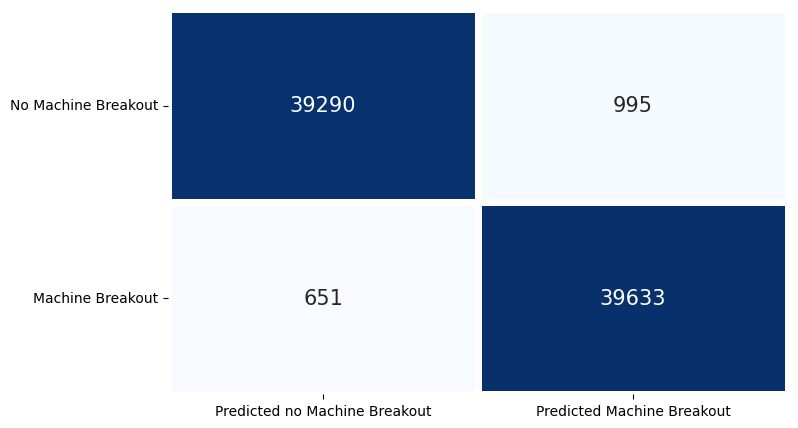

In [221]:
# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
            yticklabels = ['No Machine Breakout', 'Machine Breakout'], xticklabels = ['Predicted no Machine Breakout', 'Predicted Machine Breakout'])
plt.yticks(rotation = 0)
plt.show()

In [222]:
# K Nearest Neighbour Classifier
y_pred = knn_model.predict(X_test)
#evaluation

cm = confusion_matrix(y_test,y_pred)
TP = cm[1, 1]
FN = cm[1, 0]
sensitivity = TP / (TP + FN)
sensitivity = "{:2f}".format(sensitivity)
print(f"Sensitivity (Recall): ", sensitivity)
print(classification_report(y_test, y_pred))
results_test['K-Nearest-Neighbor Classifier'] = accuracy_score(y_test,y_pred)

Sensitivity (Recall):  0.987290
              precision    recall  f1-score   support

           0       0.99      0.91      0.94     40285
           1       0.91      0.99      0.95     40284

    accuracy                           0.95     80569
   macro avg       0.95      0.95      0.95     80569
weighted avg       0.95      0.95      0.95     80569



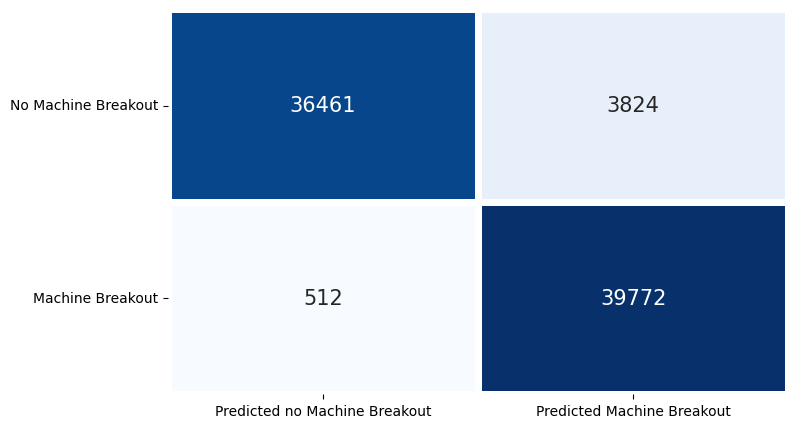

In [223]:
# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
            yticklabels = ['No Machine Breakout', 'Machine Breakout'], xticklabels = ['Predicted no Machine Breakout', 'Predicted Machine Breakout'])
plt.yticks(rotation = 0)
plt.show()

In [224]:
# XGBoost Classifier
y_pred = xgb_model.predict(X_test)
#evaluation

cm = confusion_matrix(y_test,y_pred)
TP = cm[1, 1]
FN = cm[1, 0]
sensitivity = TP / (TP + FN)
sensitivity = "{:2f}".format(sensitivity)
print(f"Sensitivity (Recall): ", sensitivity)
print(classification_report(y_test, y_pred))
results_test['XGBoost Classifier'] = accuracy_score(y_test,y_pred)

Sensitivity (Recall):  0.963410
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     40285
           1       0.97      0.96      0.97     40284

    accuracy                           0.97     80569
   macro avg       0.97      0.97      0.97     80569
weighted avg       0.97      0.97      0.97     80569



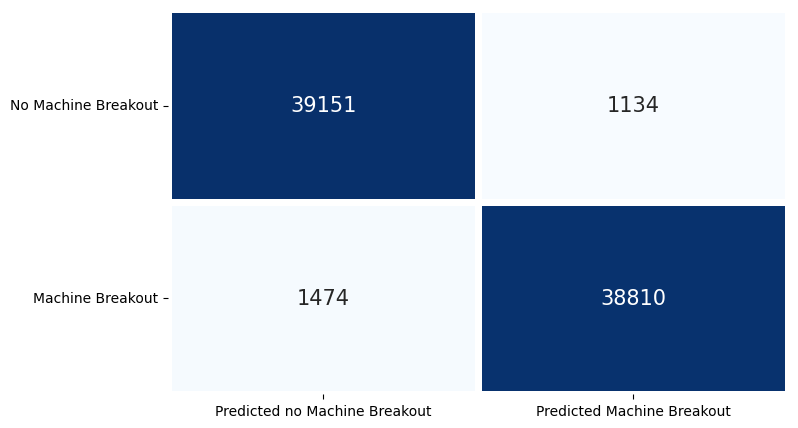

In [225]:
# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
            yticklabels = ['No Machine Breakout', 'Machine Breakout'], xticklabels = ['Predicted no Machine Breakout', 'Predicted Machine Breakout'])
plt.yticks(rotation = 0)
plt.show()

In [226]:
# LightGBM Classifier
y_pred = lgbm_model.predict(X_test)
#evaluation

cm = confusion_matrix(y_test,y_pred)
TP = cm[1, 1]
FN = cm[1, 0]
sensitivity = TP / (TP + FN)
sensitivity = "{:2f}".format(sensitivity)
print(f"Sensitivity (Recall): ", sensitivity)
print(classification_report(y_test, y_pred))
results_test['LightGBM Classifier'] = accuracy_score(y_test,y_pred)

Sensitivity (Recall):  0.969219
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     40285
           1       0.97      0.97      0.97     40284

    accuracy                           0.97     80569
   macro avg       0.97      0.97      0.97     80569
weighted avg       0.97      0.97      0.97     80569



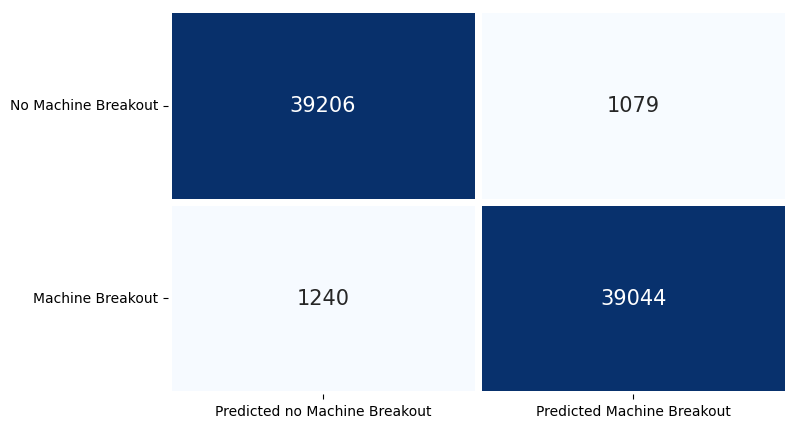

In [227]:
# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
            yticklabels = ['No Machine Breakout', 'Machine Breakout'], xticklabels = ['Predicted no Machine Breakout', 'Predicted Machine Breakout'])
plt.yticks(rotation = 0)
plt.show()

In [228]:
# CatBoost Classifier
y_pred = catboost_model.predict(X_test)
#evaluation

cm = confusion_matrix(y_test,y_pred)
TP = cm[1, 1]
FN = cm[1, 0]
sensitivity = TP / (TP + FN)
sensitivity = "{:2f}".format(sensitivity)
print(f"Sensitivity (Recall): ", sensitivity)
print(classification_report(y_test, y_pred))
results_test['CatBoost Classifier'] = accuracy_score(y_test,y_pred)

Sensitivity (Recall):  0.987017
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     40285
           1       0.99      0.99      0.99     40284

    accuracy                           0.99     80569
   macro avg       0.99      0.99      0.99     80569
weighted avg       0.99      0.99      0.99     80569



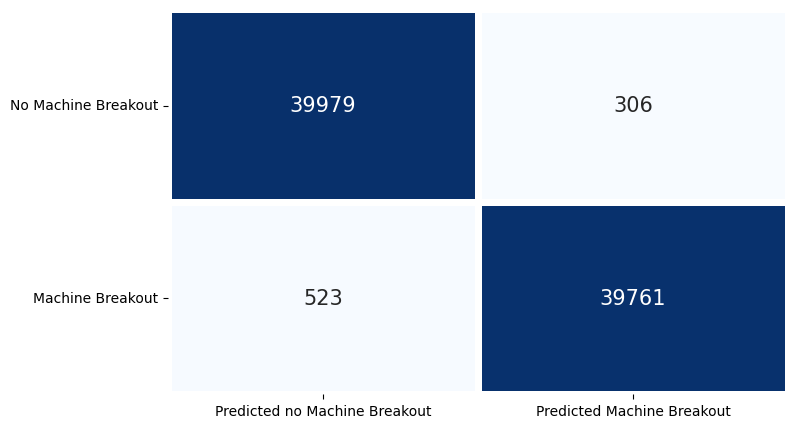

In [229]:
# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
            yticklabels = ['No Machine Breakout', 'Machine Breakout'], xticklabels = ['Predicted no Machine Breakout', 'Predicted Machine Breakout'])
plt.yticks(rotation = 0)
plt.show()

In [230]:
results_train = {
    'Logistic Regression Classifier': 0.0,
    'Decision Tree Classifier': 0.0,
    'Random Forest Classifier': 0.0,
    'K-Nearest-Neighbor Classifier': 0.0,
    'XGBoost Classifier': 0.0,
    'LightGBM Classifier': 0.0,
    'CatBoost Classifier': 0.0,
}

results_train['Logistic Regression Classifier'] = lr_model.score(X_train, y_train)
results_train['Decision Tree Classifier'] = dt_model.score(X_train, y_train)
results_train['Random Forest Classifier'] = rf_model.score(X_train, y_train)
results_train['K-Nearest-Neighbor Classifier'] = knn_model.score(X_train, y_train)
results_train['XGBoost Classifier'] = xgb_model.score(X_train, y_train)
results_train['LightGBM Classifier'] = lgbm_model.score(X_train, y_train)
results_train['CatBoost Classifier'] = catboost_model.score(X_train, y_train)

# Print the updated dictionary
print(results_train)


{'Logistic Regression Classifier': 0.7919390615608028, 'Decision Tree Classifier': 0.9996010489752278, 'Random Forest Classifier': 0.9996010489752278, 'K-Nearest-Neighbor Classifier': 0.960971951083285, 'XGBoost Classifier': 0.9722649247578368, 'LightGBM Classifier': 0.9714031905443288, 'CatBoost Classifier': 0.9921326857914923}


<Figure size 1000x600 with 0 Axes>

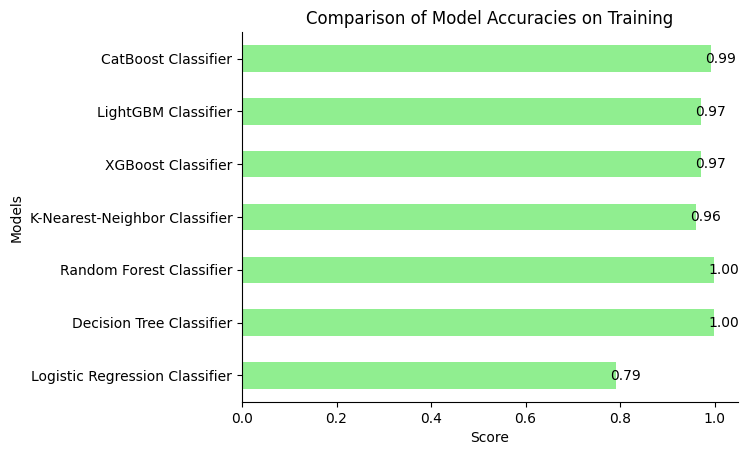

In [231]:
## creating a dataframe using pandas to illustrate the comparison on their scores
model_compare = pd.DataFrame(results_train, index=["Accuracy"])

# Plotting
plt.figure(figsize=(10, 6))

# Plotting the data using horizontal bar plot for better readability
ax = model_compare.transpose().plot(kind="barh", legend=False, color='lightgreen')

# Set labels and title
ax.set_xlabel("Score")
ax.set_ylabel("Models")
ax.set_title("Comparison of Model Accuracies on Training")

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Display the accuracy values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_width() + 0.02, p.get_y() + p.get_height()/2),
                ha='center', va='center')

# Show the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

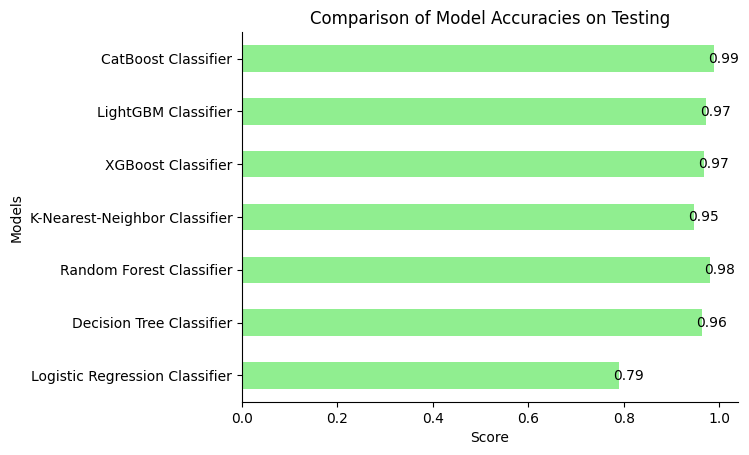

In [232]:
## creating a dataframe using pandas to illustrate the comparison on their scores
model_compare = pd.DataFrame(results_test, index=["Accuracy"])

# Plotting
plt.figure(figsize=(10, 6))

# Plotting the data using horizontal bar plot for better readability
ax = model_compare.transpose().plot(kind="barh", legend=False, color='lightgreen')

# Set labels and title
ax.set_xlabel("Score")
ax.set_ylabel("Models")
ax.set_title("Comparison of Model Accuracies on Testing")

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Display the accuracy values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_width() + 0.02, p.get_y() + p.get_height()/2),
                ha='center', va='center')

# Show the plot
plt.show()